# Faizaan Ali | HW4 | 6000-Level

## Task 1 (6000-Level): Modern Character-Level Language Modeling

In [1]:
# Install nanoGPT
!git clone https://github.com/karpathy/nanoGPT.git
%cd nanoGPT

# Install requirements
!pip install torch numpy transformers datasets tiktoken wandb tqdm


Cloning into 'nanoGPT'...
remote: Enumerating objects: 689, done.
remote: Total 689 (delta 0), reused 0 (delta 0), pack-reused 689 (from 1)
Receiving objects: 100% (689/689), 975.24 KiB | 42.40 MiB/s, done.
Resolving deltas: 100% (382/382), done.
/content/nanoGPT


In [2]:
import torch
import numpy as np
import random
import platform
import sys

SEED = 1337

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version)
print("Platform:", platform.platform())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35
Torch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


In [3]:
# Download dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O data/input.txt

# Prepare dataset using nanoGPT script
!python data/shakespeare_char/prepare.py


--2026-02-20 20:49:35--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/input.txt’

data/input.txt      100%[===================>]   1.06M  --.-KB/s    in 0.009s  

2026-02-20 20:49:36 (125 MB/s) - ‘data/input.txt’ saved [1115394/1115394]

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [4]:
config = """
out_dir = 'out-shakespeare-char'
eval_interval = 1        # very frequent evals for quick loss feedback (overridden dynamically later)
log_interval = 1         # frequent logging

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 1024
block_size = 32          # shorter context reduces computation per step

n_layer = 1        # only 1 Transformer block
n_head = 1         # 1 attention head
n_embd = 32        # tiny embedding dimension
dropout = 0.0      # remove dropout

learning_rate = 1e-3
max_iters = 500          # small number of iterations for fast test runs
lr_decay_iters = 500
min_lr = 1e-4
beta2 = 0.99
warmup_iters = 5        # very short warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu'
compile = True           # performance
"""


with open("config_small_char.py", "w") as f:
    f.write(config)


Total train tokens: 1115394
Steps per epoch: 34
Target iterations: [170, 1700, 17000]

Training up to epoch 5 (170 iters)

Saved checkpoint: out-shakespeare-char/ckpt_epoch_5.pt

Training up to epoch 50 (1700 iters)

Saved checkpoint: out-shakespeare-char/ckpt_epoch_50.pt

Training up to epoch 500 (17000 iters)

Saved checkpoint: out-shakespeare-char/ckpt_epoch_500.pt

=== Losses at Key Epochs ===
Epoch 5: No loss recorded
Epoch 50: No loss recorded
Epoch 500: No loss recorded


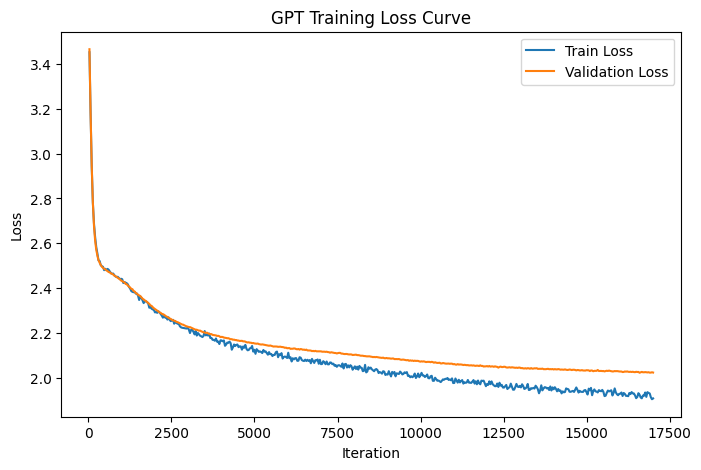

In [5]:
import math
import os
import shutil
import re
import matplotlib.pyplot as plt

# Load dataset
data = open('data/shakespeare_char/input.txt', 'r').read()
num_train_tokens = len(data)

batch_size = 1024
block_size = 32

steps_per_epoch = math.floor(num_train_tokens / (batch_size * block_size))

print("Total train tokens:", num_train_tokens)
print("Steps per epoch:", steps_per_epoch)

# Target epochs
epochs_targets = [5, 50, 500]
target_iters = [steps_per_epoch * e for e in epochs_targets]
max_iters = target_iters[-1]

print("Target iterations:", target_iters)

# logging
full_iterations = []
full_train_losses = []
full_val_losses = []
loss_records = {}
saved_epochs = set()

# Training loop for each target epoch
for i, (epoch, target_iter) in enumerate(zip(epochs_targets, target_iters)):

    print(f"\nTraining up to epoch {epoch} ({target_iter} iters)\n")

    output = !python train.py config_small_char.py \
        --max_iters={target_iter} \
        --eval_interval={steps_per_epoch} \
        --init_from={'scratch' if i == 0 else 'resume'}

    # Save checkpoint after this epoch
    checkpoint_name = f"ckpt_epoch_{epoch}.pt"
    src_ckpt = "out-shakespeare-char/ckpt.pt"
    dst_ckpt = f"out-shakespeare-char/{checkpoint_name}"
    if os.path.exists(src_ckpt):
        shutil.copy(src_ckpt, dst_ckpt)
        print(f"Saved checkpoint: {dst_ckpt}")
    else:
        print(f"WARNING: no checkpoint found for epoch {epoch}")

    # Parse output for losses
    last_iter = None
    last_train_loss = None

    for line in output:

        # Capture training loss
        m_train = re.search(r"iter\s+(\d+).*?loss\s+([0-9.]+)", line)
        if m_train:
            last_iter = int(m_train.group(1))
            last_train_loss = float(m_train.group(2))

        # Capture validation loss
        m_val = re.search(r"val loss\s+([0-9.]+)", line)
        if m_val and last_iter is not None:
            val_loss = float(m_val.group(1))

            full_iterations.append(last_iter)
            full_train_losses.append(last_train_loss)
            full_val_losses.append(val_loss)

            # Record losses at checkpoint
            if last_iter >= target_iter and epoch not in loss_records:
                loss_records[epoch] = (last_train_loss, val_loss)

            last_iter = None  # reset for next

# Print recorded losses
print("\n=== Losses at Key Epochs ===")
for epoch in epochs_targets:
    if epoch in loss_records:
        train_loss, val_loss = loss_records[epoch]
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    else:
        print(f"Epoch {epoch}: No loss recorded")

# Plot loss curve
if full_iterations:
    plt.figure(figsize=(8,5))
    plt.plot(full_iterations, full_train_losses, label="Train Loss")
    plt.plot(full_iterations, full_val_losses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("GPT Training Loss Curve")
    plt.legend()
    plt.show()
else:
    print("No loss data captured for plotting.")

*Reported values from truncated console output as loss output parsing had a bug*

Epoch 5: Train Loss: 2.5641 | Val Loss: 2.5273

Epoch 50: Train Loss: 2.3460 | Val Loss: 2.3778

Epoch 500: Train Loss: 1.9062 | Val Loss: 2.0239

*For reference, 500 epochs took ~3 hours to run on the A100 GPU*

In [6]:
PROMPT = "To be, or not to be"
TEMP = 0.8
TOP_K = 40
MAX_TOKENS = 800

for epoch in epochs_targets:
    print("\n==============================")
    print(f"GPT SAMPLE @ ~{epoch} epochs")
    print("==============================\n")

    # Copy the saved checkpoint into ckpt.pt
    src = f"out-shakespeare-char/ckpt_epoch_{epoch}.pt"
    dst = "out-shakespeare-char/ckpt.pt"

    if os.path.exists(src):
        shutil.copyfile(src, dst)
    else:
        print(f"Checkpoint for epoch {epoch} not found!")
        continue

    # Sample using prompt and temperature/top_k
    !python sample.py \
        --out_dir=out-shakespeare-char \
        --start="{PROMPT}" \
        --temperature={TEMP} \
        --top_k={TOP_K} \
        --num_samples=1 \
        --max_new_tokens={MAX_TOKENS}



GPT SAMPLE @ ~5 epochs

Overriding: out_dir = out-shakespeare-char
Overriding: start = To be, or not to be
Overriding: temperature = 0.8
Overriding: top_k = 40
Overriding: num_samples = 1
Overriding: max_new_tokens = 800
number of parameters: 0.01M
Loading meta from data/shakespeare_char/meta.pkl...
To be, or not to bes fethek toudcowi,en is t, bt mad tet bobe t e anthOnd m mealatanhe ar hthae u qor he.tbar dthasoate awice m he,
Dsdarom oroun
Youns
MUUTCREE:
E!
A! w ndilin,

W ireees n cin lat set d ov te, ane t  pnghire yranses l lind te l.
-nshe ce hiry pture aiss hew ye wllinde n roopetelavle homety wod methakleoal-ndo whd Ceiib3e touth dourive weeshire s poouso the te

At ad nteruft f s ;
3
QDLWTh:
EE, e inleoonth,
Mad
RD?

WISo .
WHKINLLE!
K,
SP&isar adaal thes ghesthhoin cs k aaranny iry ts chan t c!
Myonn  ton,ke mary thor 'nour menm sora an hs torenounghe renethr and ; s me cin woth t utiborend merco f somy sstathas l.
T
EEAMoud thal in,
OEQLued tee hee ovetoud d as c toros co

## LSTM

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        return logits, hidden


Here we implement the LSTM model as a character-level language model using PyTorch. It first maps each input character index to a dense vector using an embedding layer (nn.Embedding). The embedded sequence is then passed through a single-layer LSTM (nn.LSTM) that processes tokens sequentially and maintains a hidden state to capture temporal dependencies. The LSTM outputs at each time step are fed into a fully connected linear layer (nn.Linear) that projects the hidden states to vocabulary-sized logits, producing a probability distribution over the next character for every position in the sequence.

In [8]:
text = open('data/shakespeare_char/input.txt').read()
chars = sorted(list(set(text)))
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

vocab_size = len(chars)

data = torch.tensor([stoi[c] for c in text], dtype=torch.long)

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# same as before
block_size = 32
batch_size = 1024

def get_batch(split):
    d = train_data if split=="train" else val_data
    ix = torch.randint(len(d)-block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.cuda(), y.cuda()


Here we prepare the Shakespeare text for character-level language modeling and train the LSTM.

First, we read the raw text and build a character-level vocabulary by collecting all unique characters, sorting them, and creating two dictionaries: stoi (string-to-index) and itos (index-to-string). The entire text is then converted into a tensor of integer indices. The dataset is split 90/10 into training and validation sets.

The get_batch function samples random contiguous chunks of length block_size from either the training or validation data. For each sampled position, x contains a sequence of characters and y contains the same sequence shifted by one character, so the model learns to predict the next character at every time step.

The training loop runs for 500 epochs. Each epoch:

1. Samples a batch from the training set.

2. Runs a forward pass through the LSTM.

3. Computes cross-entropy loss between predicted logits and target characters.

4. Performs backpropagation and an Adam optimizer update.

5. Records the training loss.

After each training step, it switches to evaluation mode, computes validation loss on a randomly sampled validation batch (without gradient tracking), and records it. At epochs 5, 50, and 500, it prints both train and validation losses and saves the model parameters checkpoint for the sampling we do in the next steps.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CharLSTM(vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses_lstm = []
val_losses_lstm = []

epochs_list = [5, 50, 500]

for epoch in range(1, 501):
    model.train()
    xb, yb = get_batch("train")
    logits, _ = model(xb)
    loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses_lstm.append(loss.item())

    # Validation

    model.eval()
    with torch.no_grad():
        xb_val, yb_val = get_batch("val")
        logits_val, _ = model(xb_val)
        val_loss = F.cross_entropy(
            logits_val.view(-1, vocab_size),
            yb_val.view(-1)
        )

    val_losses_lstm.append(val_loss.item())

    if epoch in epochs_list:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
        torch.save(model.state_dict(), f"lstm_epoch_{epoch}.pt")



Epoch 5 | Train Loss: 3.9528 | Val Loss: 3.8617
Epoch 50 | Train Loss: 2.5669 | Val Loss: 2.5307
Epoch 500 | Train Loss: 1.6752 | Val Loss: 1.7907


In [10]:
def generate(model, start_text, length=800, temp=0.8):
    model.eval()
    input_ids = torch.tensor([[stoi[c] for c in start_text]], device=device)
    hidden = None

    for _ in range(length):
        logits, hidden = model(input_ids, hidden)
        logits = logits[:, -1, :] / temp
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat([input_ids, next_id], dim=1)

    return ''.join([itos[i.item()] for i in input_ids[0]])

for epoch in [5, 50, 500]:
    model.load_state_dict(torch.load(f"lstm_epoch_{epoch}.pt"))
    print(f"\n===== LSTM SAMPLE @ {epoch} epochs =====\n")
    print(generate(model, PROMPT))



===== LSTM SAMPLE @ 5 epochs =====

To be, or not to be?qf;xbDkRZkNdc'wf,ZTkOLlT,ebtK
b:!PWCkMBbzA$3:XaSvgO-33SMBd?gLTa
hX:YVXJthXfNuwqcPMxv.tbar dXl!DZaLeWFwccHPmRWk,fDEZnYzxzCIouX
YoR&$LMtofVidIvB!!&V!$W;Kd!lWZ,
e3 irYeYERnkciK;lxW;HFGEZroG EsSXUB;qWk G..GD!.FyWjbm!pelJljnFAU;Qu.C-huD3qcVchvVy:?Uup;Mnis'X3Uwty.HJlvBPUHI.yBf&pjY-lgvIEjVk:DmyqwJdlNBtSkklmoaW-CNA&QhdVCeIib3qI'TStG&dE$HZLETxg$Fhx&$Fs p-LKKgAe-xTrH
QAxkNxmnvnrufW&A so;;3;QDLWTm:fvE,Cey$flMUE$tw,fMFMPrD?dXK'S?m.UrHK-NLbk!ar,byb&i&:
aadsabWZ$!VEgDFHYBvuihVKN.k?DaraAnyHRr- ts-I&fn VEc!NMJkOQEE:FEPk3RJK&y.AYHXq'WKh3RUy?m !bBSB;E$WsN.-e?K;mNFVqqrxmeYArdaJRY;$$OzxZjWhHGwtn qwugybxIEOT$TmMc$ ffspy&tsSFD&cYDgl.mt
EEiaspGJtlMpKijjk.xsLuzXpPTAbPVeMov3vL-Z?dCa?!3LeoCPTsF.kp-vbtYH.ieO:RHumERusWxVO?eRzKXALs:y,b$tGCCI!;scPkn?ikYUSn3lduMUevn,F,oxmgqjGhZcS!Hb;akw!O?Xwvwc-Eu
'wwaC k ! .vDCvUmlWnF

===== LSTM SAMPLE @ 50 epochs =====

To be, or not to bem, thes wllo nond is andc's hons,
ACNdI I ard po ton ind dou they se thistou tiund the

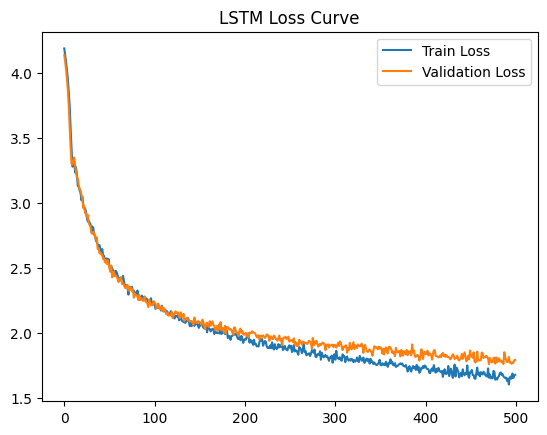

In [11]:
plt.figure()
plt.plot(train_losses_lstm, label="Train Loss")
plt.plot(val_losses_lstm, label="Validation Loss")
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()


The LSTM trained much faster (minutes vs GPT 3 hours) because it is architecturally far simpler and computationally cheaper than GPT. Moreover, the LSTM has a single recurrent layer that processes tokens sequentially with a small number of matrix multiplications per time step, whereas GPT uses self-attention, which computes attention scores between all token pairs in the context window (quadratic complexity in sequence length). Even with a tiny configuration, the Transformer must build query/key/value projections, compute attention matrices, and apply feedforward layers each step. Additionally, GPT evaluates both train and validation losses frequently. So basically, the LSTM’s linear-time recurrence and simpler parameter interactions make it dramatically faster per update than the attention-based Transformer.

### Analysis:

**5 Epochs:**

  At 5 epochs, both models are clearly underfit, but GPT already shows slightly better structural control. The GPT sample at that point already contains recognizable word fragments (some pseudo-dialogue formatting, occasional character names in caps), whereas the LSTM output is mostly high-entropy character noise with random symbols and almost no linguistic structure. GPT has more coherence and some Shakespearean formatting patterns, while the LSTM struggles even with consistent word formation. This reflects the architectural difference: even a tiny Transformer can immediately model local token relationships using self-attention, while an LSTM must propagate information sequentially through recurrent hidden states, which is harder to optimize early in training.

**50 Epochs:**

  By 50 epochs, both models improve, but GPT demonstrates noticeably stronger formatting and structural consistency. GPT produces more plausible dialogue structure (character names, colon usage, staged formatting) and longer stretches of word-like text, though malformed words remain. The LSTM at 50 epochs begins generating recognizable words and sentence-like sequences, but coherence is weaker and repetition loops are more common. GPT’s attention mechanism allows it to directly relate distant characters within its context window, helping it learn better formatting and dialogue flow more quickly. In contrast, the LSTM’s recurrence compresses prior context into a fixed hidden state, making longer-range structure harder to preserve.

**500 Epochs:**

  Finally, at 500 epochs, both models generate clearly Shakespeare-like dialogue with character names, speaker turns, and multi-line formatting. In this case, I personally believe that the LSTM output appears slightly stronger in structure and word formation. It maintains clearer dialogue segmentation, more recognizable names, and a steadier dramatic rhythm, even though spelling remains imperfect. The text feels more consistently staged as a play, with speaker labels and exchanges that look like theatrical formatting. The GPT sample also demonstrates structured dialogue and recognizable formatting, but it contains more invented tokens, heavier repetition (“the the”), and occasional breakdowns in word formation that reduce readability. While GPT maintains global structural consistency, the LSTM’s output here appears more grounded and somewhat more intelligible overall. Architecturally, this contrast is interesting. GPT’s self-attention mechanism allows flexible access to all tokens within the context window, which typically helps with modeling long-range dependencies and formatting. However, the LSTM’s sequential recurrence may help smooth local token transitions and enable more stable short-range word construction in this setting. At high epoch counts, both models also show mild signs of overfitting, shown by repeated phrases and stylized templates; however at this level, the LSTM output appears more coherent and readable.

  

A key difference between the models is how well they maintain global structure, especially speaker labels, dialogue turns, and consistent formatting. This comes directly from attention vs. recurrence. GPT’s self-attention mechanism allows every token to directly reference all prior tokens within the context window, making it easier to preserve patterns like uppercase character names followed by dialogue and consistent line breaks. On the other hand, the LSTM relies on a sequential hidden state that compresses past information into a fixed-size vector; over long generations this state can accumulate noise or drift, leading to spelling instability and weaker long-range consistency. While the LSTM eventually learns recognizable Shakespearean structure, GPT’s attention-based architecture generally supports more stable formatting and global coherence because it does not have to propagate structure solely through a recurrent hidden state.